In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import np_utils
import keras.layers as l
from keras.initializers import TruncatedNormal
from keras.models import Model
import tensorflow as tf

def split_dataset(df):
    train, test= train_test_split(df, test_size=0.2, random_state=88)

    return train, test
    

def create_one_hot_labels(Y_train, Y_test, labels):
    encoder = LabelEncoder()
    encoder.fit(labels)

    Y_train = encoder.transform(Y_train)
    Y_test = encoder.transform(Y_test)

    n_classes = np.max(Y_train) + 1

    Y_train = np_utils.to_categorical(Y_train, n_classes)
    Y_test = np_utils.to_categorical(Y_test, n_classes)

    return Y_train, Y_test, n_classes

Get data

In [2]:
import pandas as pd

amazon_data = pd.read_csv("../cleaned/amazon-cleaned.csv",index_col=0)
amazon_labels = amazon_data.category.unique()

shopmania_data = pd.read_csv("../cleaned/shopmania-cleaned.csv", index_col=0)
shopmania_labels = shopmania_data.category.unique()

custom_data = pd.read_csv("../cleaned/custom-cleaned.csv", index_col=0)
custom_labels = custom_data.category.unique()

datasets = {'amazon': [amazon_data.copy(), amazon_labels], 'shopmania': [shopmania_data.copy(), shopmania_labels], 'custom': [custom_data.copy(), custom_labels]}

In [3]:
amazon_data = amazon_data.dropna()

In [4]:
shopmania_data = shopmania_data.dropna()

In [5]:
custom_data = custom_data.dropna()

In [6]:
amazon_data.sample(3)

,item_name,category
5008,ameriphone ttyvcohco machine for cellcordless ...,landline_phones
878,erayak vv a automatic battery charger car main...,battery_chargers
9398,samsung galaxy s i gb unlocked gsm g lte andro...,unlocked_cell_phones


In [7]:
shopmania_data.sample(3)

,item_name,category
4537,allen heath gl,Audio / DJ Equipment
174,baby gap outlet long sleeve turtleneck size t ...,Crafts
6036,task essential skin feed active moisturizer m...,Men Cosmetics


In [8]:
custom_data.sample(3)

,store_name,item_name,category
496.0,LiDL,tenderstem broccoli,groceries
408.0,TEA TERRACE,cream tea for,eating out
8.0,TESCO,cc butternut soup,groceries


In [6]:
from transformers import TFBertModel, BertConfig, BertTokenizerFast

c:\Users\grace\.conda\envs\FYP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
model_name = 'bert-base-uncased'

max_len = 100

config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

In [14]:
def bert(df, d_labels):
    tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=config)

    transformer_model = TFBertModel.from_pretrained(model_name, config = config)
    
    bert = transformer_model.layers[0]

    input_ids = l.Input(shape=(24,), name="inputs", dtype='int32')
    inputs = {'input_ids': input_ids}

    bert_model = bert(inputs)[1]

    dropout = l.Dropout(config.hidden_dropout_prob, name='pooled_output')
    pooled_output = dropout(bert_model, training=False)

    category = l.Dense(
        units=len(df.category.value_counts()),
        kernel_initializer=TruncatedNormal(stddev=config.initializer_range),
        name = 'category'
        )(pooled_output)

    outputs= {'category': category}
    model = Model(inputs=inputs, outputs=outputs, name="BERT_multilabel")

    X_train, X_test = split_dataset(df)
    Y_train, Y_test, n_classes = create_one_hot_labels(X_train['category'], X_test['category'], d_labels)

    x = tokenizer(
        text=X_train['item_name'].astype(str).to_list(),
        add_special_tokens = True,
        max_length = 24,
        truncation = True,
        padding = True,
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = False,
        verbose=True
    )

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=5e-05,
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0
    )

    loss = {'category': tf.keras.losses.CategoricalCrossentropy(from_logits = True)}
    metric = {'category': tf.keras.metrics.CategoricalAccuracy('accuracy')}

    model.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = metric
    )

    history = model.fit(
        x={'input_ids': x['input_ids']},
        y={'category': Y_train},
        validation_split=0.2,
        batch_size=20,
        epochs=30
    )

    return history

In [8]:
histories = []

In [15]:
for key, dataset in datasets.items():
    history = bert(dataset[0], dataset[1])
    
    metrics = [[history.history['val_accuracy'][-1], history.history['val_loss'][-1]]]

    histories.append(history)

    print(key)
    print(metrics)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/30
320/320 [==============================] - 33s 78ms/step - loss: 3.8210 - accuracy: 0.3319 - val_loss: 2.9770 - val_accuracy: 0.6119
Epoch 2/30
320/320 [==============================] - 24s 76ms/step - loss: 2.6589 - accuracy: 0.6888 - val_loss: 2.3454 - val_accuracy: 0.7131
Epoch 3/30
320/320 [==============================] - 24s 76ms/step - loss: 2.1602 - accuracy: 0.7697 - val_loss: 2.0105 - val_accuracy: 0.7494
Epoch 4/30
320/320 [==============================] - 24s 76ms/step - loss: 1.8653 - accuracy: 0.8100 - val_loss: 1.7980 - val_accuracy: 0.7775
Epoch 5/30
320/320 [==============================] - 24s 76ms/step - loss: 1.6631 - accuracy: 0.8333 - val_loss: 1.6464 - val_accuracy: 0.7887
Epoch 6/30
320/320 [==============================] - 24s 76ms/step - loss: 1.5102 - accuracy: 0.8494 - val_loss: 1.5366 - val_accuracy: 0.8031
Epoch 7/30
320/320 [==============================] - 24s 76ms/step - loss: 1.3942 - accuracy: 0.8564 - val_loss: 1.4489 - val_accuracy:

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/30
359/359 [==============================] - 45s 95ms/step - loss: 4.6317 - accuracy: 0.1398 - val_loss: 4.0726 - val_accuracy: 0.3411
Epoch 2/30
359/359 [==============================] - 33s 91ms/step - loss: 3.8390 - accuracy: 0.4158 - val_loss: 3.6010 - val_accuracy: 0.4593
Epoch 3/30
359/359 [==============================] - 33s 91ms/step - loss: 3.4448 - accuracy: 0.5160 - val_loss: 3.3225 - val_accuracy: 0.5078
Epoch 4/30
359/359 [==============================] - 33s 92ms/step - loss: 3.1925 - accuracy: 0.5660 - val_loss: 3.1299 - val_accuracy: 0.5446
Epoch 5/30
359/359 [==============================] - 33s 91ms/step - loss: 3.0104 - accuracy: 0.5915 - val_loss: 2.9867 - val_accuracy: 0.5602
Epoch 6/30
359/359 [==============================] - 33s 91ms/step - loss: 2.8642 - accuracy: 0.6136 - val_loss: 2.8728 - val_accuracy: 0.5792
Epoch 7/30
359/359 [==============================] - 33s 91ms/step - loss: 2.7436 - accuracy: 0.6382 - val_loss: 2.7798 - val_accuracy:

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/30


ValueError: in user code:

    File "c:\Users\grace\.conda\envs\FYP\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\grace\.conda\envs\FYP\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\grace\.conda\envs\FYP\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\grace\.conda\envs\FYP\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\grace\.conda\envs\FYP\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\grace\.conda\envs\FYP\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "BERT_multilabel" is incompatible with the layer: expected shape=(None, 24), found shape=(20, 15)


In [11]:
def bert_custom(df, d_labels):
    tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=config)

    transformer_model = TFBertModel.from_pretrained(model_name, config = config)
    
    bert = transformer_model.layers[0]

    input_ids = l.Input(shape=(15,), name="inputs", dtype='int32')
    inputs = {'input_ids': input_ids}

    bert_model = bert(inputs)[1]

    dropout = l.Dropout(config.hidden_dropout_prob, name='pooled_output')
    pooled_output = dropout(bert_model, training=False)

    category = l.Dense(
        units=len(df.category.value_counts()),
        kernel_initializer=TruncatedNormal(stddev=config.initializer_range),
        name = 'category'
        )(pooled_output)

    outputs= {'category': category}
    model = Model(inputs=inputs, outputs=outputs, name="BERT_multilabel")

    X_train, X_test = split_dataset(df)
    Y_train, Y_test, n_classes = create_one_hot_labels(X_train['category'], X_test['category'], d_labels)

    x = tokenizer(
        text=X_train['item_name'].astype(str).to_list(),
        add_special_tokens = True,
        max_length = 15,
        truncation = True,
        padding = True,
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = False,
        verbose=True
    )

    print(x)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=5e-05,
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0
    )

    loss = {'category': tf.keras.losses.CategoricalCrossentropy(from_logits = True)}
    metric = {'category': tf.keras.metrics.CategoricalAccuracy('accuracy')}

    model.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = metric
    )

    history = model.fit(
        x={'input_ids': x['input_ids']},
        y={'category': Y_train},
        validation_split=0.2,
        batch_size=20,
        epochs=30
    )

    model.summary()
    
    return history

In [12]:
history = bert_custom(datasets['custom'][0], datasets['custom'][1])
    
metrics = [[history.history['val_accuracy'][-1], history.history['val_loss'][-1]]]

histories.append(history)

print(metrics)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


{'input_ids': <tf.Tensor: shape=(526, 15), dtype=int32, numpy=
array([[  101, 14380,  9648, ...,     0,     0,     0],
       [  101, 20482, 11840, ...,     0,     0,     0],
       [  101, 16480,  2278, ...,     0,     0,     0],
       ...,
       [  101, 10507,  7708, ...,     0,     0,     0],
       [  101,  9781,  2006, ...,     0,     0,     0],
       [  101,  6861, 15723, ...,     0,     0,     0]])>}
Epoch 1/30
21/21 [==============================] - 11s 146ms/step - loss: 1.8816 - accuracy: 0.5190 - val_loss: 1.8202 - val_accuracy: 0.5094
Epoch 2/30
21/21 [==============================] - 1s 69ms/step - loss: 1.5562 - accuracy: 0.5333 - val_loss: 1.6423 - val_accuracy: 0.5094
Epoch 3/30
21/21 [==============================] - 1s 70ms/step - loss: 1.3436 - accuracy: 0.5929 - val_loss: 1.4548 - val_accuracy: 0.5943
Epoch 4/30
21/21 [==============================] - 1s 70ms/step - loss: 1.0667 - accuracy: 0.7048 - val_loss: 1.2863 - val_accuracy: 0.6132
Epoch 5/30
21/21 [==

# Graphs

In [14]:
import matplotlib.pyplot as plt
def train_val_graph(history, metric, name):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])

    plt.title(f'History of {metric} over epochs ({name} dataset)')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['training '+metric, 'validation '+metric])

    plt.show()

In [23]:
histories[0] = [histories[0], 'amazon']
histories[1] = [histories[1], 'shopmania']

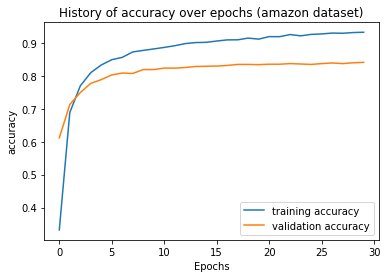

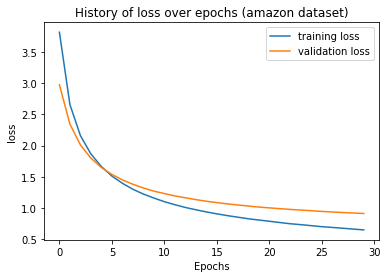

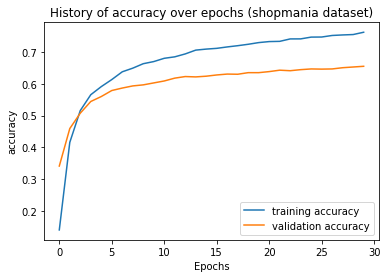

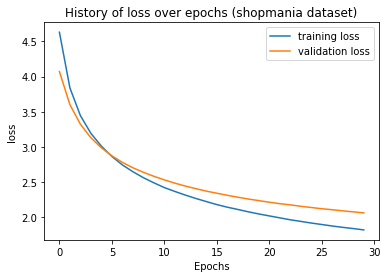

In [26]:
for history in histories:
    train_val_graph(history[0], "accuracy", history[1])
    train_val_graph(history[0], "loss", history[1])

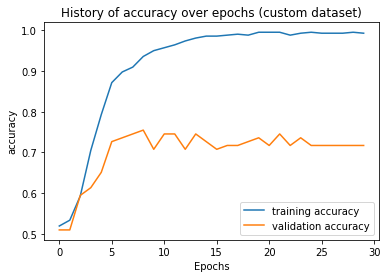

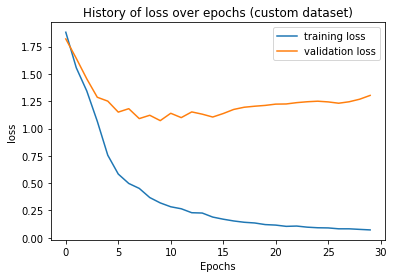

In [15]:
train_val_graph(histories[0], "accuracy", 'custom')
train_val_graph(histories[0], "loss", 'custom')